In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import time,math
import random,os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,SimpleRNN,GRU,Dropout,BatchNormalization
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Setting seeds
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


In [ ]:
# Specification
TICKER = 'BTC-USD'
START_DATE = '2018-01-01'
END_DATE = None
VIZ_SAMPLE_DAYS = 1000

In [ ]:
print('Download the data for:', TICKER)
df = yf.download(TICKER,START_DATE,END_DATE, progress = False)
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop = True)
df

Download the data for: BTC-USD


Price,Date,Close,High,Low,Open,Volume
Ticker,,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
0,2018-01-01,13657.200195,14112.200195,13154.700195,14112.200195,10291200000
1,2018-01-02,14982.099609,15444.599609,13163.599609,13625.000000,16846600192
2,2018-01-03,15201.000000,15572.799805,14844.500000,14978.200195,16871900160
3,2018-01-04,15599.200195,15739.700195,14522.200195,15270.700195,21783199744
4,2018-01-05,17429.500000,17705.199219,15202.799805,15477.200195,23840899072
...,...,...,...,...,...,...
2831,2025-10-02,120681.257812,121086.406250,118383.156250,118652.382812,71415163912
2832,2025-10-03,122266.531250,123944.703125,119344.312500,120656.984375,83941392228
2833,2025-10-04,122425.429688,122857.640625,121577.570312,122267.468750,36769171735


In [ ]:
# USER SETTINGS - adjust these
# ----------------------------
TIME_STEPS = 30        # sequence length
EPOCHS = 50
BATCH_SIZE = 32
CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

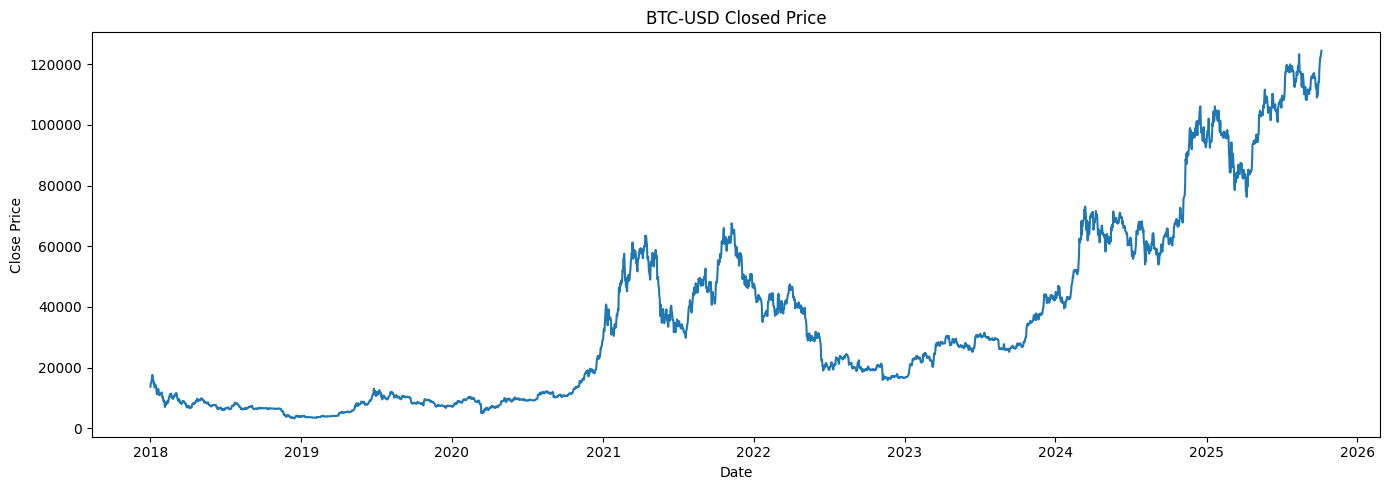

In [ ]:
# plot
plt.figure(figsize =(14, 5))
plt.plot(df['Date'],df['Close'])
plt.title('BTC-USD Closed Price')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

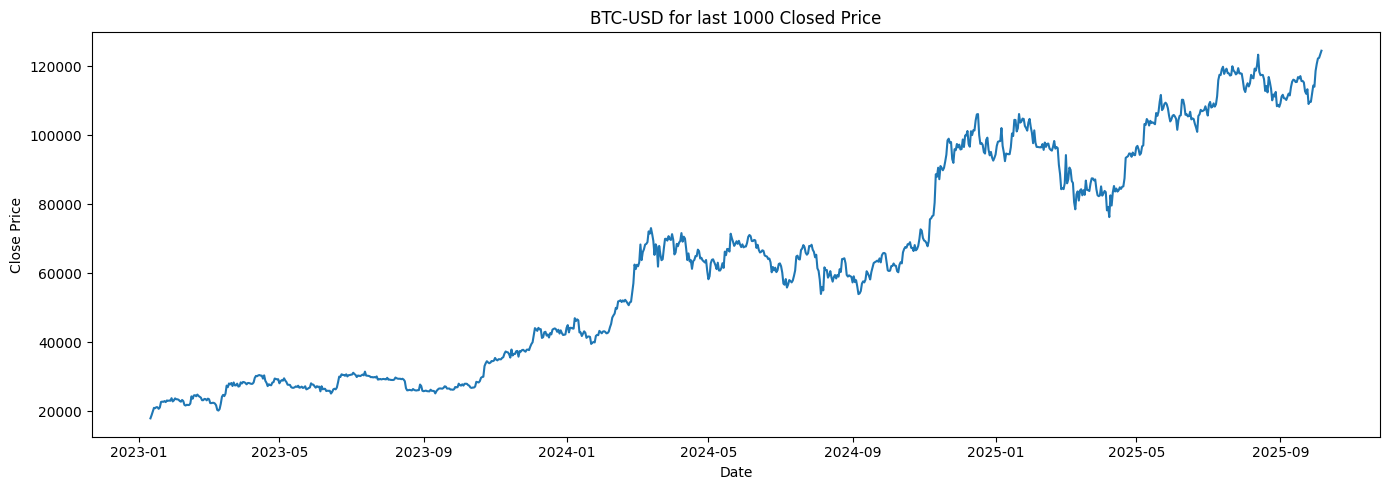

In [ ]:
# plot for last 1000 days
plt.figure(figsize=(14,5))
plt.plot((df['Date'].iloc[-VIZ_SAMPLE_DAYS:]),(df['Close'].iloc[-VIZ_SAMPLE_DAYS:]))
plt.title(f'BTC-USD for last {VIZ_SAMPLE_DAYS} Closed Price')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

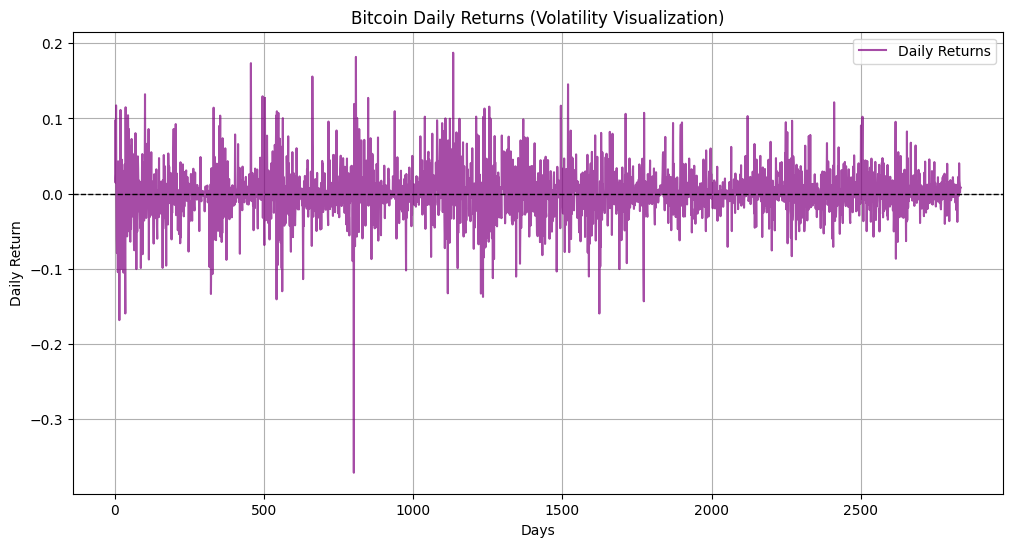

In [ ]:
# Calculate daily returns
df['Daily Return'] = df['Close'].pct_change().dropna()

# Plot daily returns
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Daily Return'], label='Daily Returns', color='purple', alpha=0.7)

plt.title("Bitcoin Daily Returns (Volatility Visualization)")
plt.xlabel("Days")
plt.ylabel("Daily Return")
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # baseline
plt.legend()
plt.grid(True)
plt.show()

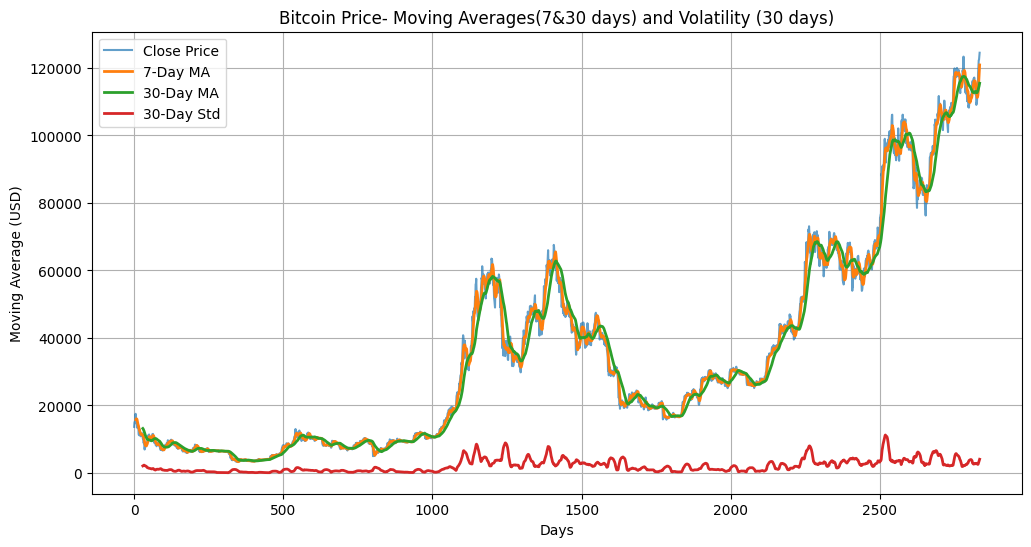

In [ ]:
# Calculate moving averages (MA)
# ma = df['Close']  # This line is causing ma to be a Series
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA30'] = df['Close'].rolling(window=30).mean()
df['Volatility'] = df['Close'].rolling(window=30).std()
#df['MA100'] = df['Close'].rolling(window=30).mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Close Price', alpha=0.7)
plt.plot(df.index, df['MA7'], label='7-Day MA', linewidth=2)
plt.plot(df.index, df['MA30'], label='30-Day MA', linewidth=2)
plt.plot(df.index, df['Volatility'], label='30-Day Std',linewidth=2)
#plt.plot(df.index, df['MA100'], label='100-Day MA', linewidth=2)

plt.title("Bitcoin Price- Moving Averages(7&30 days) and Volatility (30 days)")
plt.xlabel("Days")
plt.ylabel("Moving Average (USD)")
plt.legend()
plt.grid(True)
plt.show()

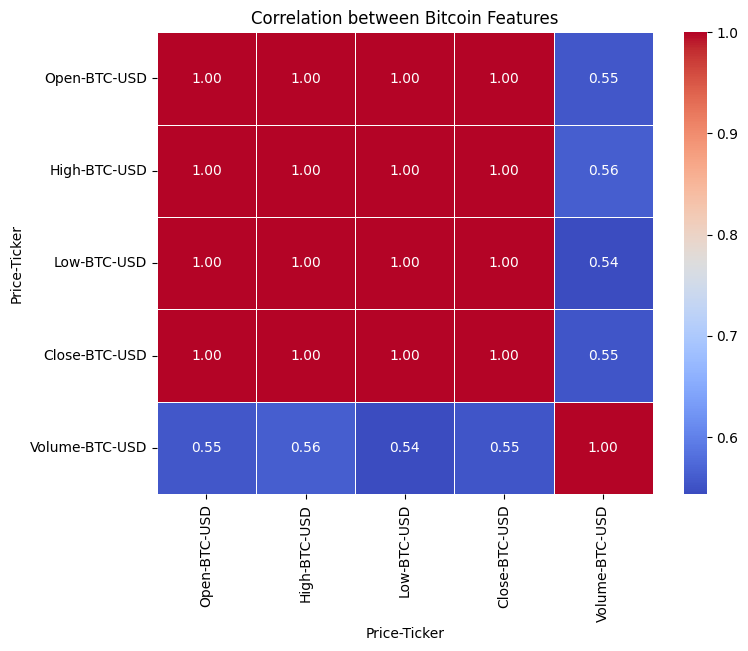

In [ ]:

# Select features of interest
features = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# Compute correlation matrix
corr_matrix = features.corr()

# Plot correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation between Bitcoin Features")
plt.show()

**Highly Corrected except for volume**

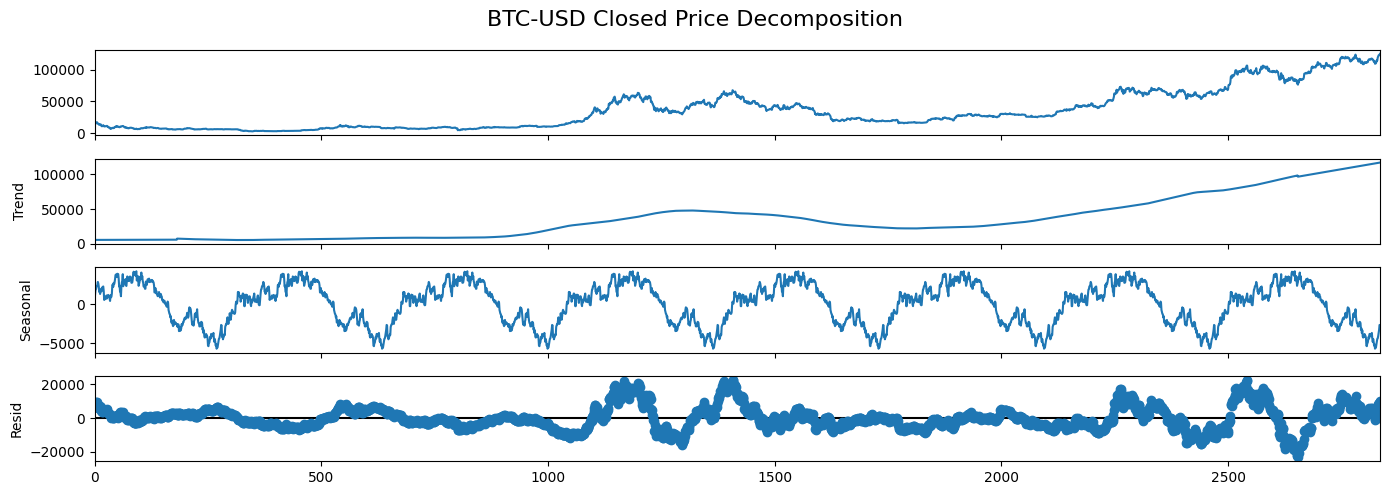

In [ ]:
# Decomposition
try:
  decomposed_period = 365 # a year
  decomposed = seasonal_decompose(df['Close'],
                                  model = 'Multiplicative',
                                  period=decomposed_period,
                                  extrapolate_trend='freq')
  fig = decomposed.plot()
  fig.set_size_inches(14, 5)
  plt.suptitle('BTC-USD Closed Price Decomposition', fontsize=16)
  plt.tight_layout()
  plt.show()
except Exception as e:
  print('Seasonal Decomposition skipped {reason} :', e)

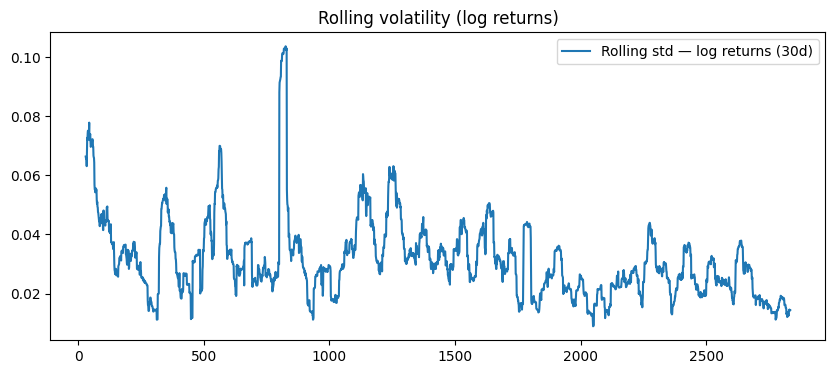

ADF price p-value: 0.9888452481855154
ADF logret p-value: 2.0223929891284776e-30
ARCH LM p-value: 1.985812003932911e-10


In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch

prices = df['Close'].sort_index().astype('float32')
logp = np.log(prices)
logret = logp.diff().dropna()

# convert to numpy arrays
logret_values = logret.values.reshape(-1, 1)     # shape (n, 1)
price_values = prices.values.reshape(-1, 1)      # shape (n+1, 1), careful with offsets

n = len(logret_values)   # number of usable returns
# rolling standard deviation (30-day)
roll_std_price = prices.pct_change().rolling(30).std()
roll_std_logret = logret.rolling(30).std()

# plot rolling vol
plt.figure(figsize=(10,4))
plt.plot(roll_std_logret, label='Rolling std — log returns (30d)')
plt.title('Rolling volatility (log returns)')
plt.legend(); plt.show()

# stationarity test (ADF)
adf_price = adfuller(prices.dropna())
adf_logret = adfuller(logret.dropna())
print("ADF price p-value:", adf_price[1])
print("ADF logret p-value:", adf_logret[1])

# ARCH test for heteroskedasticity (volatility clustering)
arch_stat = het_arch(logret.dropna(), nlags=12)
# returns (lm_stat, lm_pvalue, f_stat, f_pvalue)
print("ARCH LM p-value:", arch_stat[1])


**What the numbers tell us**

ADF price p-value = 0.9825
Very large p-value → fail to reject the unit root. The price series is non-stationary (has a unit root / trend). That matches intuition for Bitcoin.

ADF logret p-value = 0.0
Effectively zero → reject the unit root. Log returns are stationary in mean. Good — this justifies modeling returns instead of raw prices for the mean process.

ARCH LM p-value ≈ 1.31e-24
Extremely small → strong evidence of ARCH effects. In plain words: the variance is time-varying (volatility clustering). Large shocks tend to be followed by large shocks.

In [ ]:
# Preprocessing

# ----  Robust feature engineering ----
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -1 * delta.clip(upper=0)
    ma_up = gain.ewm(alpha=1/period, adjust=False).mean()
    ma_down = loss.ewm(alpha=1/period, adjust=False).mean()
    rs = ma_up / (ma_down + 1e-12)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return macd_line, signal_line, macd_hist

ma_short = 7
ma_long  = 30
vol_window = 30
rsi_period = 30
macd_fast, macd_slow, macd_signal = 12, 26, 9

# Perform feature engineering on the DataFrame
df_feat = df[['Close','Volume']].copy() # Create a copy to avoid modifying the original df

df_feat['log_volume'] = np.log1p(df_feat['Volume'])
df_feat['logret'] = np.log(df_feat['Close'] / df_feat['Close'].shift(1))

df_feat[f'ma_{ma_short}'] = df_feat['logret'].rolling(window=ma_short, min_periods=1).mean()
df_feat[f'ma_{ma_long}']  = df_feat['logret'].rolling(window=ma_long, min_periods=1).mean()

df_feat[f'volatility_{vol_window}'] = df_feat['logret'].rolling(window=vol_window, min_periods=1).std()

df_feat[f'rsi_{rsi_period}'] = compute_rsi(df_feat['Close'], period=rsi_period)

macd_line, macd_signal_line, macd_hist = compute_macd(df_feat['Close'],
                                                     fast=macd_fast,
                                                     slow=macd_slow,
                                                     signal=macd_signal)
df_feat['macd_line'] = macd_line
df_feat['macd_signal'] = macd_signal_line
df_feat['macd_hist'] = macd_hist

df_feat['lag1_logret'] = df_feat['logret'].shift(1)
df_feat['target'] = df_feat['logret'].shift(-1)

# ---- 4) Diagnostic: how many NaNs remain ----
feature_cols = ['log_volume', f'ma_{ma_short}', f'ma_{ma_long}',
                f'volatility_{vol_window}', f'rsi_{rsi_period}',
                'macd_line', 'macd_signal', 'macd_hist', 'lag1_logret']

print("NaNs per column after feature-engineering:")
print(df_feat[feature_cols + ['target']].isna().sum())

# ---- 5) Trim warmup rows and final row (target NaN) ----
warmup = max(ma_long, vol_window, macd_slow, rsi_period)
print("warmup:", warmup)

# We drop the first 'warmup' rows and the very last row (target is NaN due to shift(-1))
df_clean = df_feat.iloc[warmup:-1].copy()
print("Rows after warmup trim:", df_clean.shape[0])
print("Final NaN count:", df_clean.isna().sum().sum())
# Drop 'Close' and 'Volume' columns from df_clean
df_clean = df_clean.drop(columns=['Close','Volume'])
# Final X, y ready for scaling/sequencing
X = df_clean[feature_cols].copy()
y = df_clean['target'].copy()
print("Final X NaN count:", X.isna().sum().sum())
print("X shape, y shape:", X.shape, y.shape)

NaNs per column after feature-engineering:
Price          Ticker
log_volume               0
ma_7                     1
ma_30                    1
volatility_30            2
rsi_30                   1
macd_line                0
macd_signal              0
macd_hist                0
lag1_logret              2
target                   1
dtype: int64
warmup: 30
Rows after warmup trim: 2805
Final NaN count: 0
Final X NaN count: 0
X shape, y shape: (2805, 9) (2805,)


In [ ]:
# Select features to scale (excluding the target column)
feature_cols_to_scale = [col for col in df_clean.columns if col != 'target']

scaler = MinMaxScaler()
# Fit and transform the selected features
X_scaled_df = pd.DataFrame(scaler.fit_transform(df_clean[feature_cols_to_scale]),
                           columns=feature_cols_to_scale,
                           index=df_clean.index)

# Combine scaled features with the target
df_scaled = pd.concat([X_scaled_df, df_clean['target']], axis=1)

display(df_scaled.head())
print("df_scaled shape:", df_scaled.shape)

,"(log_volume, )","(logret, )","(ma_7, )","(ma_30, )","(volatility_30, )","(rsi_30, )","(macd_line, )","(macd_signal, )","(macd_hist, )","(lag1_logret, )","(target, )",target
30,0.211313,0.747820,0.527694,0.370042,0.606138,0.794481,0.346847,0.338058,0.448473,0.555188,0.559692,-0.108458
31,0.255997,0.559692,0.421877,0.252778,0.600515,0.750446,0.338229,0.334479,0.430188,0.747820,0.670762,-0.037756
32,0.307210,0.670762,0.390105,0.222296,0.598892,0.736488,0.330140,0.329814,0.416995,0.559692,0.790138,0.038233
33,0.190077,0.790138,0.405415,0.229513,0.602310,0.743084,0.327068,0.325398,0.420016,0.670762,0.568280,-0.102991
34,0.184534,0.568280,0.264399,0.104732,0.571859,0.705791,0.319773,0.320240,0.411005,0.790138,0.456756,-0.173982


df_scaled shape: (2805, 12)


In [ ]:
train_size = int(len(X_scaled_df) * 0.7)
val_size   = int(len(X_scaled_df) * 0.15)

X_train, X_val, X_test = X_scaled_df[:train_size], X_scaled_df[train_size:train_size+val_size], X_scaled_df[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]


In [ ]:
# Combine scaled features and target
data_scaled = df_scaled.values

# Updated create_sequences function to work with combined data
def create_sequences(data, time_steps):
    Xs, ys = [], []
    # Loop up to len(data) to include the last possible target
    for i in range(time_steps, len(data)):
        # X is the sequence of features and target up to i-1
        Xs.append(data[i - time_steps:i, :])
        # y is the target at index i
        ys.append(data[i, -1]) # Assuming target is the last column

    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(data_scaled, TIME_STEPS)

print("Original scaled data shape:", data_scaled.shape)
print("Sequences created:")
print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)

# Split the sequences into training, validation, and test sets
train_size_seq = int(len(X_seq) * 0.7)
val_size_seq   = int(len(X_seq) * 0.15)

X_train_seq, X_val_seq, X_test_seq = X_seq[:train_size_seq], X_seq[train_size_seq:train_size_seq+val_size_seq], X_seq[train_size_seq+val_size_seq:]
y_train_seq, y_val_seq, y_test_seq = y_seq[:train_size_seq], y_seq[train_size_seq:train_size_seq+val_size_seq], y_seq[train_size_seq+val_size_seq:]


print("\nSplitted sequences:")
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("X_val_seq shape:", X_val_seq.shape)
print("y_val_seq shape:", y_val_seq.shape)
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)

Original scaled data shape: (2805, 12)
Sequences created:
X_seq shape: (2775, 30, 12)
y_seq shape: (2775,)

Splitted sequences:
X_train_seq shape: (1942, 30, 12)
y_train_seq shape: (1942,)
X_val_seq shape: (416, 30, 12)
y_val_seq shape: (416,)
X_test_seq shape: (417, 30, 12)
y_test_seq shape: (417,)


In [ ]:
n_features =X.shape[-1]
early_stop = EarlyStopping(monitor = 'val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Function for RNN
def build_rnn(units_list = [64], dropout = 0.2, input_shape = (TIME_STEPS, n_features)):
  model = Sequential()
  for i, units in enumerate(units_list):
    return_seq = (i < len(units_list) - 1)
    if i == 0:
      model.add(SimpleRNN(units, return_sequences = return_seq, input_shape = input_shape))
    else:
      model.add(SimpleRNN(units, return_sequences = return_seq))
    model.add(Dropout(dropout))
  model.add(Dense(1)) # Output a single value for the target
  model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
  return model

In [ ]:
# Function for LSTM
def build_lstm(units_list = [64], dropout = 0.2, input_shape = (TIME_STEPS, n_features)):
  model = Sequential()
  for i, units in enumerate(units_list):
    return_seq = (i < len(units_list) - 1)
    if i == 0:
      model.add(LSTM(units, return_sequences = return_seq, input_shape = input_shape))
    else:
      model.add(LSTM(units, return_sequences = return_seq))
    model.add(Dropout(dropout))
  model.add(Dense(1)) # Output a single value for the target
  model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
  return model

In [ ]:
# Function for GRU
def build_gru(units_list = [64], dropout = 0.2, input_shape = (TIME_STEPS, n_features)):
  model = Sequential()
  for i, units in enumerate(units_list):
    return_seq = (i < len(units_list) - 1)
    if i == 0:
      model.add(GRU(units, return_sequences = return_seq, input_shape = input_shape))
    else:
      model.add(GRU(units, return_sequences = return_seq))
    model.add(Dropout(dropout))
  model.add(Dense(1)) # Output a single value for the target
  model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
  return model

In [ ]:
configs = [
    ('RNN-32', build_rnn(units_list = [32], dropout = 0.1, input_shape = (TIME_STEPS, X_train_seq.shape[-1]))),
    ('RNN-64-32', build_rnn(units_list = [64, 32], dropout = 0.2, input_shape = (TIME_STEPS, X_train_seq.shape[-1]))),
    ('RNN-128-64-32', build_rnn(units_list = [128, 64, 32], dropout = 0.3, input_shape = (TIME_STEPS, X_train_seq.shape[-1]))),
    ('LSTM-32', build_lstm(units_list = [32], dropout = 0.1, input_shape = (TIME_STEPS, X_train_seq.shape[-1]))),
    ('LSTM-64-32', build_lstm(units_list = [64, 32], dropout = 0.2, input_shape = (TIME_STEPS, X_train_seq.shape[-1]))),
    ('LSTM-128-64-32', build_lstm(units_list = [128, 64, 32], dropout = 0.3, input_shape = (TIME_STEPS, X_train_seq.shape[-1]))),
    ('GRU-32', build_gru(units_list = [32], dropout = 0.1, input_shape = (TIME_STEPS, X_train_seq.shape[-1]))),
    ('GRU-64-32', build_gru(units_list = [64, 32], dropout = 0.2, input_shape = (TIME_STEPS, X_train_seq.shape[-1]))),
    ('GRU-128-64-32', build_gru(units_list = [128, 64, 32], dropout = 0.3, input_shape = (TIME_STEPS, X_train_seq.shape[-1]))),
]

In [ ]:
# Training all the variants and recording metrics and runtime
history = {}
results = {}
timings = {}
predictions = {}

for name, model in configs:
  print("\n============================================================================")
  print('Training Model :', name)
  print('\n', model.summary())
  start = time.time()
  h =  model.fit(
      X_train_seq, y_train_seq, # Use sequential data for training
      epochs = EPOCHS,
      batch_size = BATCH_SIZE,
      validation_split = 0.15,
      callbacks = [early_stop],
      verbose = 1
  )
  elapsed = time.time() - start

  # Predict and rescale the target
  y_pred_scaled = model.predict(X_test_seq) # Use sequential data for prediction

  # Create a temporary array with the same number of features as the scaler was fitted on
  # and place the predictions in the target column's position (last column)
  temp_array = np.zeros((len(y_pred_scaled), scaler.n_features_in_))
  temp_array[:, -1] = y_pred_scaled.flatten() # Place predictions in the last column

  # Inverse transform the temporary array
  y_pred_rescaled = scaler.inverse_transform(temp_array)[:, -1] # Extract the target column

  # Do the same for the true values
  temp_array_true = np.zeros((len(y_test_seq), scaler.n_features_in_))
  temp_array_true[:, -1] = y_test_seq.flatten()
  y_test_rescaled = scaler.inverse_transform(temp_array_true)[:, -1]


  # Evaluate the model
  # The target is now the only column after inverse_transform, so index is 0
  rmse = math.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
  mae = np.mean(np.abs(y_pred_rescaled - y_test_rescaled))

  print(f"{name} RMSE (Close) : {rmse:.3f}, MAE (Close) : {mae:.3f}, Time : {elapsed:.1f}s")
  history[name] = h.history
  results[name] = [rmse, mae]
  timings[name] = elapsed
  predictions[name] = {"y_true" : y_test_rescaled, "y_pred" : y_pred_rescaled}


Training Model : RNN-32


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,473 (5.75 KB)

 Trainable params: 1,473 (5.75 KB)

 Non-trainable params: 0 (0.00 B)


 None
Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0658 - mae: 0.1990 - val_loss: 0.0061 - val_mae: 0.0629
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0201 - mae: 0.1090 - val_loss: 0.0024 - val_mae: 0.0365
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0121 - mae: 0.0849 - val_loss: 0.0022 - val_mae: 0.0358
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0099 - mae: 0.0783 - val_loss: 0.0021 - val_mae: 0.0362
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0078 - mae: 0.0691 - val_loss: 0.0022 - val_mae: 0.0379
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0068 - mae: 0.0634 - val_loss: 0.0012 - val_mae: 0.0253
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0056 - mae: 0.0578 - val_loss: 0.0012 - val_mae: 0.0255
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0051 - mae: 0.0525 - val_loss: 0.0010 - val_mae: 0.0226
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 30, 64)         │         4,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,065 (31.50 KB)

 Trainable params: 8,065 (31.50 KB)

 Non-trainable params: 0 (0.00 B)


 None
Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.2842 - mae: 0.4183 - val_loss: 0.0069 - val_mae: 0.0664
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0856 - mae: 0.2328 - val_loss: 0.0043 - val_mae: 0.0542
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0556 - mae: 0.1883 - val_loss: 0.0020 - val_mae: 0.0346
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0351 - mae: 0.1513 - val_loss: 0.0017 - val_mae: 0.0324
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0266 - mae: 0.1305 - val_loss: 0.0016 - val_mae: 0.0311
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0205 - mae: 0.1151 - val_loss: 0.0013 - val_mae: 0.0285
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0149 - mae: 0.0977 - val_loss: 0.0016 - val_mae: 0.0309
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0137 - mae: 0.0908 - val_loss: 0.0013 - val_mae: 0.0277
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 30, 128)        │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 30, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,537 (131.00 KB)

 Trainable params: 33,537 (131.00 KB)

 Non-trainable params: 0 (0.00 B)


 None
Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.4937 - mae: 0.5669 - val_loss: 0.0162 - val_mae: 0.1235
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.3284 - mae: 0.4587 - val_loss: 0.0297 - val_mae: 0.1698
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.2148 - mae: 0.3690 - val_loss: 0.0093 - val_mae: 0.0927
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1620 - mae: 0.3206 - val_loss: 0.0121 - val_mae: 0.1062
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1112 - mae: 0.2673 - val_loss: 0.0065 - val_mae: 0.0757
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0964 - mae: 0.2505 - val_loss: 0.0470 - val_mae: 0.2147
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0795 - mae: 0.2255 - val_loss: 0.0175 - val_mae: 0.1294
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0576 - mae: 0.1901 - val_loss: 0.0036 - val_mae: 0.0547
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,793 (22.63 KB)

 Trainable params: 5,793 (22.63 KB)

 Non-trainable params: 0 (0.00 B)


 None
Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0109 - mae: 0.0797 - val_loss: 0.0011 - val_mae: 0.0254
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0043 - mae: 0.0496 - val_loss: 9.8905e-04 - val_mae: 0.0227
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - mae: 0.0409 - val_loss: 9.4716e-04 - val_mae: 0.0222
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0026 - mae: 0.0381 - val_loss: 8.7611e-04 - val_mae: 0.0209
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - mae: 0.0347 - val_loss: 8.1773e-04 - val_mae: 0.0196
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0020 - mae: 0.0327 - val_loss: 8.0396e-04 - val_mae: 0.0193
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0018 - mae: 0.0305 - val_loss: 7.9818e-04 - val_mae: 0.0191
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018 - mae: 0.0293 - val_loss: 8.3268e-04 - val_mae: 0.0201
Epoch 9/50
52/52 ━━━━━━━━━━━━

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,161 (125.63 KB)

 Trainable params: 32,161 (125.63 KB)

 Non-trainable params: 0 (0.00 B)


 None
Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0128 - mae: 0.0855 - val_loss: 7.5564e-04 - val_mae: 0.0192
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0024 - mae: 0.0369 - val_loss: 7.4437e-04 - val_mae: 0.0186
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0021 - mae: 0.0337 - val_loss: 7.3676e-04 - val_mae: 0.0182
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0020 - mae: 0.0327 - val_loss: 8.0327e-04 - val_mae: 0.0204
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0019 - mae: 0.0325 - val_loss: 7.9713e-04 - val_mae: 0.0202
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0018 - mae: 0.0311 - val_loss: 8.8071e-04 - val_mae: 0.0221
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
LSTM-64-32 RMSE (Close) : 0.015, MAE (Close) : 0.010, Time : 14.6s

Training Model : LSTM-128-64-32


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 128)        │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,049 (523.63 KB)

 Trainable params: 134,049 (523.63 KB)

 Non-trainable params: 0 (0.00 B)


 None
Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0144 - mae: 0.0857 - val_loss: 7.7374e-04 - val_mae: 0.0184
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0017 - mae: 0.0289 - val_loss: 7.3919e-04 - val_mae: 0.0182
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.0018 - mae: 0.0293 - val_loss: 7.4476e-04 - val_mae: 0.0185
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0017 - mae: 0.0290 - val_loss: 7.5148e-04 - val_mae: 0.0187
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0017 - mae: 0.0288 - val_loss: 7.8426e-04 - val_mae: 0.0197
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
LSTM-128-64-32 RMSE (Close) : 0.015, MAE (Close) : 0.010, Time : 29.8s

Training Model : GRU-32


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         4,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,449 (17.38 KB)

 Trainable params: 4,449 (17.38 KB)

 Non-trainable params: 0 (0.00 B)


 None
Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0315 - mae: 0.1373 - val_loss: 0.0016 - val_mae: 0.0315
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0124 - mae: 0.0872 - val_loss: 8.4704e-04 - val_mae: 0.0216
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0077 - mae: 0.0684 - val_loss: 7.4048e-04 - val_mae: 0.0182
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0048 - mae: 0.0538 - val_loss: 7.3489e-04 - val_mae: 0.0180
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0034 - mae: 0.0453 - val_loss: 7.4121e-04 - val_mae: 0.0182
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0026 - mae: 0.0393 - val_loss: 7.6258e-04 - val_mae: 0.0193
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0025 - mae: 0.0374 - val_loss: 8.1491e-04 - val_mae: 0.0208
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
GRU-32 RMSE (Close) : 0.015, MAE (Close) : 0.011, Time : 11.1s

Training Model : GRU-64-32


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 30, 64)         │        14,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,417 (95.38 KB)

 Trainable params: 24,417 (95.38 KB)

 Non-trainable params: 0 (0.00 B)


 None
Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0153 - mae: 0.0939 - val_loss: 9.8412e-04 - val_mae: 0.0225
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0036 - mae: 0.0458 - val_loss: 7.6280e-04 - val_mae: 0.0181
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0026 - mae: 0.0383 - val_loss: 7.5430e-04 - val_mae: 0.0180
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0024 - mae: 0.0357 - val_loss: 7.4254e-04 - val_mae: 0.0181
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0021 - mae: 0.0337 - val_loss: 7.5769e-04 - val_mae: 0.0180
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0018 - mae: 0.0299 - val_loss: 7.5570e-04 - val_mae: 0.0188
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0019 - mae: 0.0315 - val_loss: 8.0225e-04 - val_mae: 0.0200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
GRU-64-32 RMSE (Close) : 0.015, MAE (Close) : 0.011, Time : 19.5s

Training Model : GRU-128-64-32


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 30, 128)        │        54,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 30, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,217 (395.38 KB)

 Trainable params: 101,217 (395.38 KB)

 Non-trainable params: 0 (0.00 B)


 None
Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 0.0115 - mae: 0.0807 - val_loss: 7.4257e-04 - val_mae: 0.0185
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0026 - mae: 0.0386 - val_loss: 7.6229e-04 - val_mae: 0.0191
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0024 - mae: 0.0355 - val_loss: 8.7312e-04 - val_mae: 0.0217
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0022 - mae: 0.0346 - val_loss: 8.0138e-04 - val_mae: 0.0200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
GRU-128-64-32 RMSE (Close) : 0.015, MAE (Close) : 0.011, Time : 22.9s


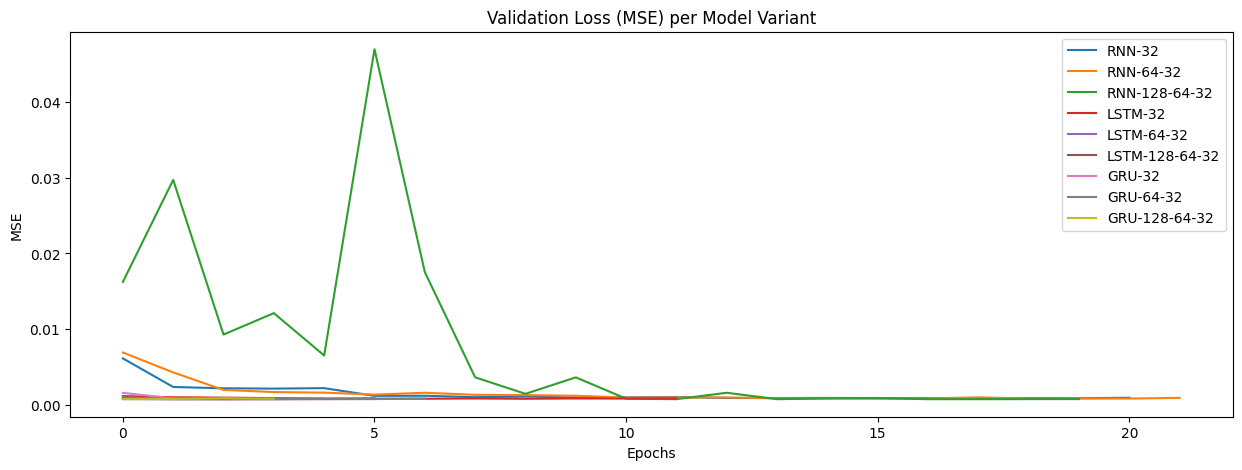

In [ ]:
# Visual Comparison
plt.figure(figsize = (15, 5))
for name, h in history.items():
  if "val_loss" in h:
    plt.plot(h['val_loss'], label = name)
plt.title("Validation Loss (MSE) per Model Variant")
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

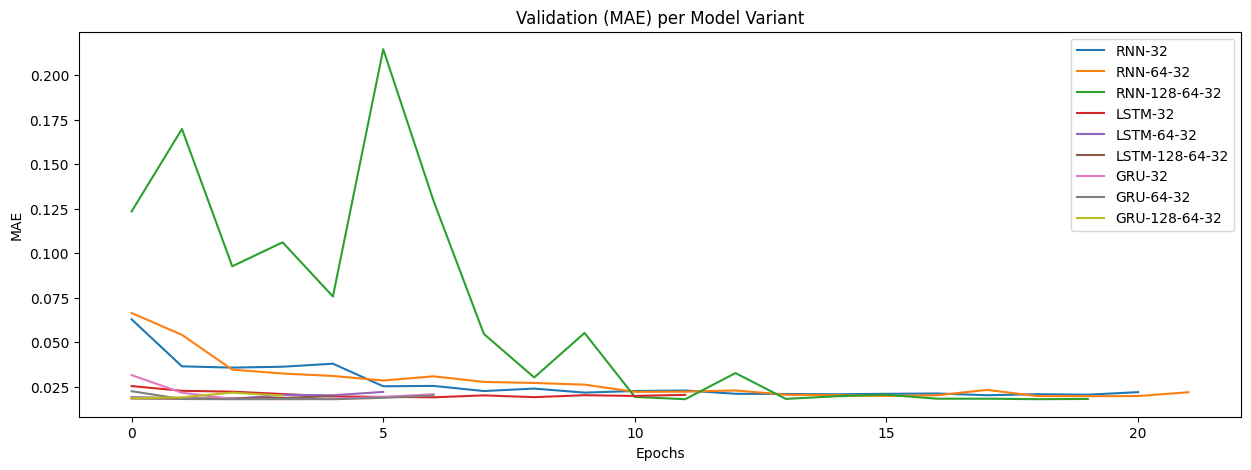

In [ ]:
# Visual Comparison
plt.figure(figsize = (15, 5))
for name, h in history.items():
  if "val_mae" in h:
    plt.plot(h['val_mae'], label = name)
plt.title("Validation (MAE) per Model Variant")
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


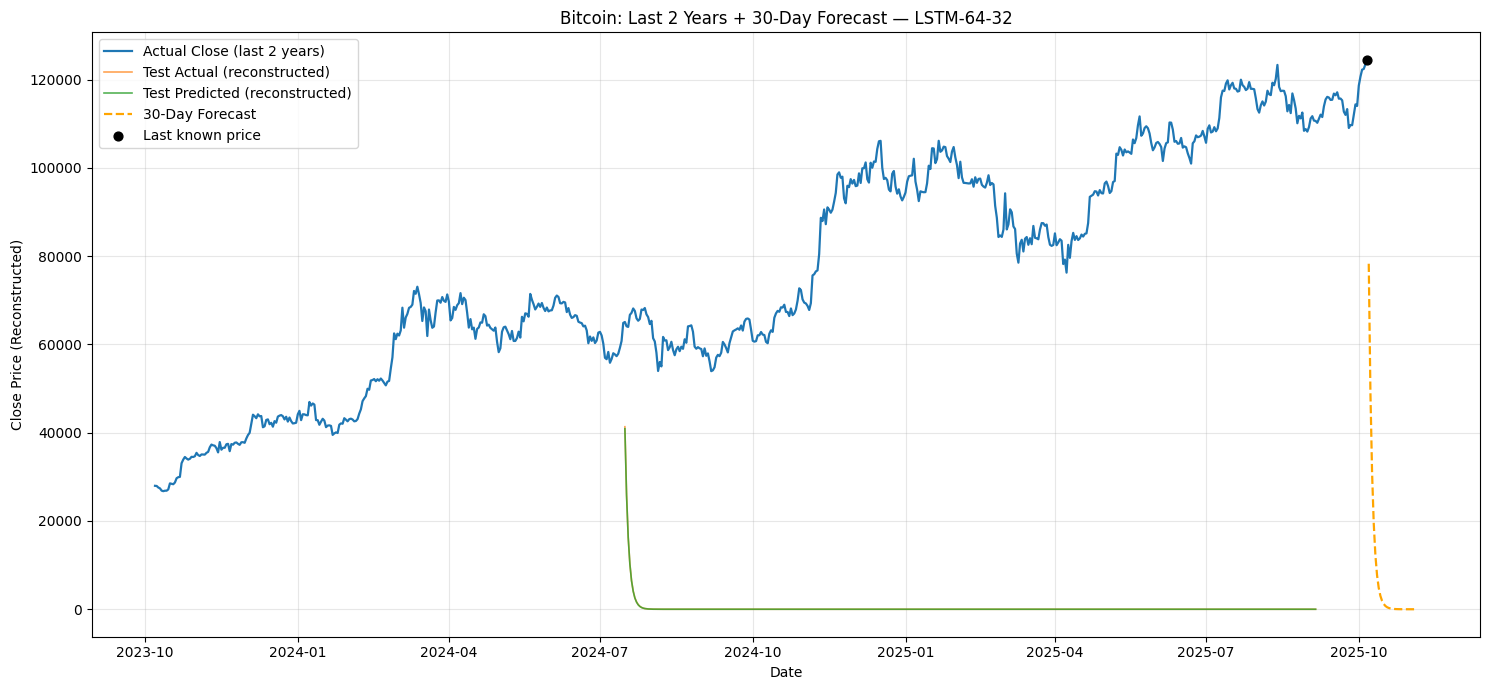

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# --- 1️⃣ Select best model by MAE ---
best_mae = float('inf')
best_name = None
for name, metrics in results.items():
    if metrics[1] < best_mae:
        best_mae = metrics[1]
        best_name = name

y_true = predictions[best_name]['y_true']
y_pred = predictions[best_name]['y_pred']

# --- 2️⃣ Find starting price before test set ---
start_index_of_first_test_target_in_df_clean = df_clean.index[0] + train_size_seq + val_size_seq
price_start_index_in_df = start_index_of_first_test_target_in_df_clean - 1
if price_start_index_in_df < 0 or price_start_index_in_df >= len(df):
    raise IndexError(f"Start price index {price_start_index_in_df} out of bounds.")
price_start_scalar = float(df['Close'].iloc[price_start_index_in_df])

# --- 3️⃣ Convert cumulative log returns → prices ---
true_prices = price_start_scalar * np.exp(np.cumsum(y_true))
pred_prices = price_start_scalar * np.exp(np.cumsum(y_pred))

# --- 4️⃣ Create date range for test predictions ---
test_dates = df['Date'].iloc[start_index_of_first_test_target_in_df_clean:
                             start_index_of_first_test_target_in_df_clean + len(y_true)].reset_index(drop=True)

# --- 5️⃣ 30-Day Forecast (chained from last predicted log-returns) ---
FORECAST_DAYS = 30
last_known_date = df['Date'].iloc[-1]
last_known_price = float(df['Close'].iloc[-1])

# Use mean of last 7 predicted log-returns as forward drift estimate
drift_logret = np.mean(y_pred[-7:])
forecast_logrets = np.repeat(drift_logret, FORECAST_DAYS)
forecast_prices = last_known_price * np.exp(np.cumsum(forecast_logrets))
forecast_dates = pd.date_range(start=last_known_date + pd.Timedelta(days=1),
                               periods=FORECAST_DAYS, freq='D')

# --- 6️⃣ Select last 2 years of actual prices ---
LAST_YEARS_DAYS = 365 * 2
cutoff_date = last_known_date - pd.Timedelta(days=LAST_YEARS_DAYS)
df_last2y = df[df['Date'] >= cutoff_date].copy().reset_index(drop=True)
if df_last2y.empty:
    print("⚠️ No rows in last 2 years; plotting full dataset instead.")
    df_last2y = df.copy()

# --- 7️⃣ Plot all together ---
plt.figure(figsize=(15, 7))
plt.plot(df_last2y['Date'], df_last2y['Close'], label='Actual Close (last 2 years)', lw=1.6)
plt.plot(test_dates, true_prices, label='Test Actual (reconstructed)', lw=1.2, alpha=0.7)
plt.plot(test_dates, pred_prices, label='Test Predicted (reconstructed)', lw=1.2, alpha=0.8)
plt.plot(forecast_dates, forecast_prices, '--', color='orange', lw=1.6,
         label=f'{FORECAST_DAYS}-Day Forecast')
plt.scatter([last_known_date], [last_known_price], color='black', s=40, zorder=5, label='Last known price')

plt.title(f"Bitcoin: Last 2 Years + {FORECAST_DAYS}-Day Forecast — {best_name}")
plt.xlabel("Date")
plt.ylabel("Close Price (Reconstructed)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Since the prediction and forecast is really bad.I was searching for the good pre-trained model but not able to find. So let try encoder and decoder**

In [ ]:
# Prepare data for training
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

btc_df = df
btc_df = btc_df.sort_index()
btc_df['logret_close'] = np.log(btc_df['Close']).diff().fillna(0)

# Select features — log returns + volume-based info
features = ['logret_close', 'Volume']
btc_df['log_volume'] = np.log(btc_df['Volume'].replace(0, np.nan)).fillna(0)
btc_df['logvol_ret'] = btc_df['log_volume'].diff().fillna(0)
features = ['logret_close', 'log_volume', 'logvol_ret']

# Normalize
scaler = StandardScaler()
btc_df[features] = scaler.fit_transform(btc_df[features])

# Create sequences
def create_windows(btc_df, features, input_len=14, target_len=7):
    X, y = [], []
    values = btc_df[features].values
    for i in range(len(values) - input_len - target_len):
        X.append(values[i:i+input_len])
        y.append(btc_df['logret_close'].values[i+input_len:i+input_len+target_len])
    return np.array(X), np.array(y)

INPUT_LEN = 30
TARGET_LEN = 7
X, y = create_windows(btc_df, features, INPUT_LEN, TARGET_LEN)

# Split
n = len(X)
train_end = int(n * 0.8)
val_end = int(n * 0.9)
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]


In [ ]:
def attention_block(inputs):
    # Simple additive attention
    score = layers.Dense(1, activation='tanh')(inputs)
    attention_weights = layers.Softmax(axis=1)(score)
    # Wrap tf.reduce_sum in a Lambda layer or custom layer
    context = layers.Lambda(lambda x: tf.reduce_sum(x[0] * x[1], axis=1))([inputs, attention_weights])
    return context

def build_encoder(input_len, n_features, cnn_filters=32, lstm_units=128, dropout=0.2):
    inp = layers.Input(shape=(input_len, n_features))
    x = layers.Conv1D(cnn_filters, 3, padding='causal', activation='relu')(inp)
    x = layers.Conv1D(cnn_filters, 3, padding='causal', activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True, recurrent_dropout=0.1))(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units//2, return_sequences=True, recurrent_dropout=0.1))(x)
    x = attention_block(x)
    x = layers.Dropout(dropout)(x)
    return models.Model(inp, x, name='encoder')

In [ ]:
def build_forecast_model(encoder, target_len):
    inp = encoder.input
    x = encoder.output
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(target_len)(x)  # predict log-returns directly
    model = models.Model(inp, out)
    return model

n_features = X_train.shape[2]
encoder = build_encoder(INPUT_LEN, n_features)
model = build_forecast_model(encoder, TARGET_LEN)
model.summary()


Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 30, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 30, 32)    │        320 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 32)    │      3,104 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 15, 32)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 15, 256)   │    164,864 │ max_pooling1d[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 15, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 15, 1)     │        129 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 15, 1)     │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ bidirectional_1[… │
│                     │                   │            │ softmax[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 128)       │          0 │ lambda[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      8,256 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 7)         │        455 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 341,480 (1.30 MB)

 Trainable params: 341,480 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='mse',
              metrics=['mae'])

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stop, reduce_lr],
                    verbose=2)

# Save encoder for future transfer learning
encoder.save_weights('btc_encoder_weights.weights.h5')

Epoch 1/100
70/70 - 23s - 328ms/step - loss: 1.0885 - mae: 0.6881 - val_loss: 0.5961 - val_mae: 0.5701 - learning_rate: 1.0000e-04
Epoch 2/100
70/70 - 9s - 123ms/step - loss: 1.0871 - mae: 0.6874 - val_loss: 0.5957 - val_mae: 0.5697 - learning_rate: 1.0000e-04
Epoch 3/100
70/70 - 9s - 127ms/step - loss: 1.0871 - mae: 0.6877 - val_loss: 0.5955 - val_mae: 0.5696 - learning_rate: 1.0000e-04
Epoch 4/100
70/70 - 10s - 148ms/step - loss: 1.0870 - mae: 0.6878 - val_loss: 0.5953 - val_mae: 0.5697 - learning_rate: 1.0000e-04
Epoch 5/100
70/70 - 8s - 118ms/step - loss: 1.0867 - mae: 0.6877 - val_loss: 0.5952 - val_mae: 0.5696 - learning_rate: 1.0000e-04
Epoch 6/100
70/70 - 7s - 98ms/step - loss: 1.0868 - mae: 0.6879 - val_loss: 0.5953 - val_mae: 0.5696 - learning_rate: 1.0000e-04
Epoch 7/100
70/70 - 8s - 114ms/step - loss: 1.0856 - mae: 0.6872 - val_loss: 0.5953 - val_mae: 0.5697 - learning_rate: 1.0000e-04
Epoch 8/100
70/70 - 10s - 147ms/step - loss: 1.0852 - mae: 0.6875 - val_loss: 0.5953 - va

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step


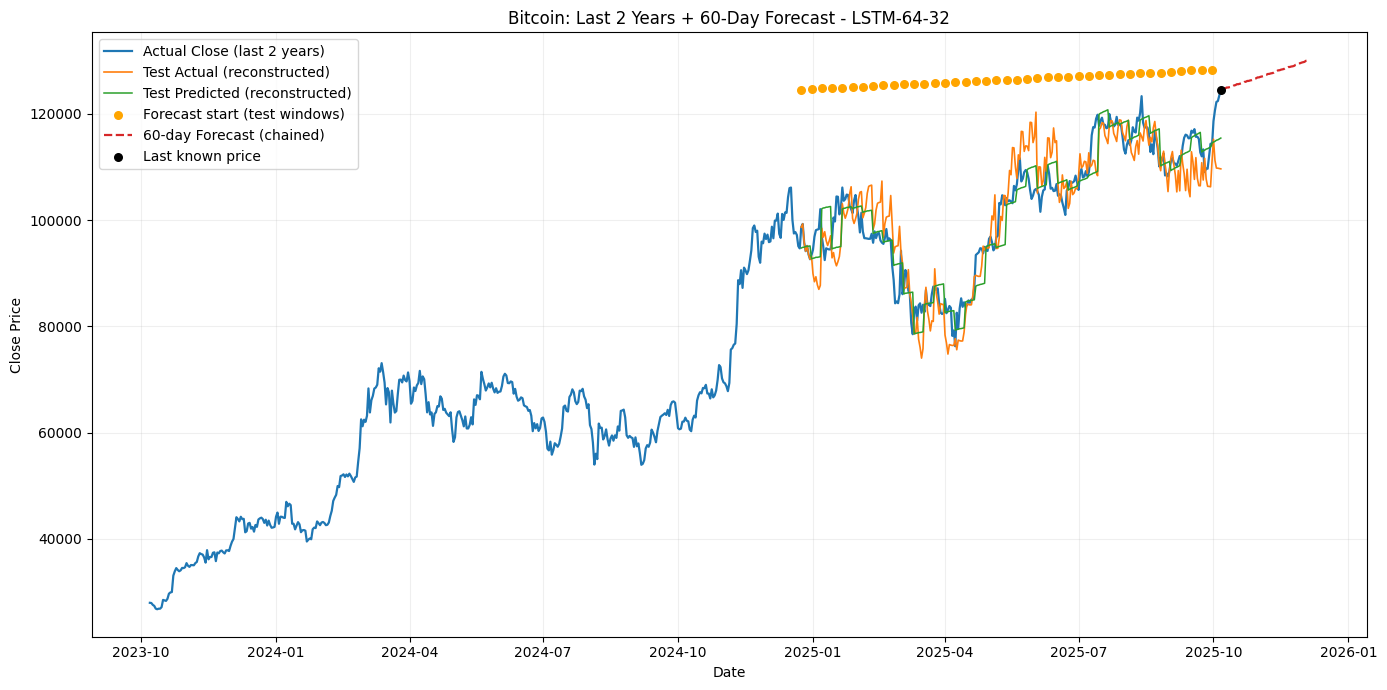

In [ ]:
#prediction
y_pred = model.predict(X_test)


# --- Preconditions / quick safety checks ---
assert 'Date' in df.columns and 'Close' in df.columns, "df must contain 'Date' and 'Close' columns"
df['Date'] = pd.to_datetime(df['Date'])
assert y_test.shape[0] == y_pred.shape[0], "y_test and y_pred must have same number of sequences"
num_windows = y_test.shape[0]

# --- Parameters for plotting / forecast ---
FORECAST_DAYS = 60   # user requested 60-day forward forecast
LAST_YEARS_DAYS = 365 * 2  # last 2 years ~ 730 days

# --- Helper: inverse-transform log-returns (first column) ---
def inverse_transform_logrets(logret_array_1d):
    stacked = np.hstack((
        logret_array_1d.reshape(-1, 1),
        np.zeros((len(logret_array_1d), n_features - 1))
    ))
    inv = scaler.inverse_transform(stacked)
    return inv[:, 0]

# --- Reconstruct test-period (per-window, no chaining across windows) ---
start_idx = val_end + INPUT_LEN                            # first predicted date index in df
requested_total_timesteps = num_windows * TARGET_LEN

if not (1 <= start_idx < len(df)):
    raise IndexError(f"start_idx ({start_idx}) is outside dataframe bounds (len(df)={len(df)}). "
                     "Check val_end and INPUT_LEN. start_idx should be >=1 and < len(df).")

available_timesteps = len(df) - start_idx
if available_timesteps <= 0:
    raise IndexError(f"No available timesteps after start_idx={start_idx}. available_timesteps={available_timesteps}")

# Determine how many windows we can actually use (fit in df). Allow partial last window if needed.
max_windows_from_data = available_timesteps // TARGET_LEN
remainder_days = available_timesteps % TARGET_LEN

if requested_total_timesteps > available_timesteps:
    if max_windows_from_data == 0:
        if remainder_days > 0:
            windows_to_use = 1
            partial_last_window = True
            used_timesteps = remainder_days
            print(f"Warning: plotting a single truncated window of {remainder_days} days.")
        else:
            raise IndexError("Not enough data to plot any prediction window. Decrease TARGET_LEN or adjust val_end/INPUT_LEN.")
    else:
        windows_to_use = max_windows_from_data
        partial_last_window = False
        used_timesteps = windows_to_use * TARGET_LEN
        print(f"Warning: Requested test predictions ({requested_total_timesteps} days) exceed available ({available_timesteps}). "
              f"Trimming to {windows_to_use} full window(s) -> {used_timesteps} days plotted.")
else:
    windows_to_use = num_windows
    partial_last_window = False
    used_timesteps = requested_total_timesteps

# Build date index for plotted test period using real df dates
end_idx = start_idx + used_timesteps
dates_test = df['Date'].iloc[start_idx:end_idx].reset_index(drop=True)

all_actual_prices = []
all_predicted_prices = []
forecast_dates = []
forecast_prices = []

for i in range(windows_to_use):
    window_start_idx = start_idx + i * TARGET_LEN
    base_price_idx = window_start_idx - 1
    if base_price_idx < 0 or base_price_idx >= len(df):
        raise IndexError(f"Base price index {base_price_idx} out of bounds for window {i}")

    base_price = float(df['Close'].iloc[base_price_idx])

    # determine length to take for this window
    if (i == windows_to_use - 1) and partial_last_window:
        take_len = remainder_days
    else:
        take_len = TARGET_LEN

    y_test_lr = inverse_transform_logrets(y_test[i].reshape(-1,))[:take_len]
    y_pred_lr = inverse_transform_logrets(y_pred[i].reshape(-1,))[:take_len]

    actual_window_prices = base_price * np.exp(np.cumsum(y_test_lr))
    pred_window_prices = base_price * np.exp(np.cumsum(y_pred_lr))

    all_actual_prices.extend(actual_window_prices.tolist())
    all_predicted_prices.extend(pred_window_prices.tolist())

    # forecast start-of-window info
    forecast_dates.append(df['Date'].iloc[window_start_idx])
    forecast_prices.append(pred_window_prices[0])

# Trim to match dates_test if mismatch
min_len = min(len(dates_test), len(all_actual_prices), len(all_predicted_prices))
if min_len < len(dates_test):
    print(f"Trimming plotted arrays to min length {min_len}.")
dates_test = dates_test.iloc[:min_len]
all_actual_prices = all_actual_prices[:min_len]
all_predicted_prices = all_predicted_prices[:min_len]

# --- Build 60-day forward forecast from last available price ---
last_known_date = df['Date'].iloc[-1]
last_known_price = float(df['Close'].iloc[-1])

# Flatten predicted log-returns from the model outputs (use y_pred sequences in order)
flattened_pred_logrets = []
for i in range(num_windows):
    lr = inverse_transform_logrets(y_pred[i].reshape(-1,))
    flattened_pred_logrets.extend(lr.tolist())

# If the flattened predictions are shorter than FORECAST_DAYS, repeat the last window (or pad with mean) to reach required days
if len(flattened_pred_logrets) < FORECAST_DAYS:
    needed = FORECAST_DAYS - len(flattened_pred_logrets)
    if len(flattened_pred_logrets) >= TARGET_LEN:
        # repeat the last TARGET_LEN block as needed
        last_block = flattened_pred_logrets[-TARGET_LEN:]
        repeats = math.ceil(needed / len(last_block))
        flattened_pred_logrets.extend((last_block * repeats)[:needed])
        print(f"Warning: not enough predicted log-returns to cover {FORECAST_DAYS} days. Repeating last window to fill {needed} days.")
    else:
        # fallback: pad using mean of available predicted log-returns
        pad_values = [np.mean(flattened_pred_logrets)] * needed if flattened_pred_logrets else [0.0] * needed
        flattened_pred_logrets.extend(pad_values)
        print(f"Warning: flattened predictions are small; padding {needed} days with mean or zeros.")

# Now take exactly FORECAST_DAYS log-returns
forecast_logrets = np.array(flattened_pred_logrets[:FORECAST_DAYS])

# chain them starting from last_known_price
forecast_prices = last_known_price * np.exp(np.cumsum(forecast_logrets))
forecast_dates_future = pd.date_range(start=last_known_date + pd.Timedelta(days=1), periods=FORECAST_DAYS, freq='D')

# --- Build last-2-years window for plotting historical actuals ---
cutoff_date = last_known_date - pd.Timedelta(days=LAST_YEARS_DAYS)
df_last2y = df[df['Date'] >= cutoff_date].copy().reset_index(drop=True)
if df_last2y.empty:
    print("Warning: df has no rows in the last 2 years; plotting full df instead.")
    df_last2y = df.copy()

# --- Plot: last 2 years actual, test predictions (if overlapping), and 60-day forecast ---
plt.figure(figsize=(14, 7))

# 1) plot last 2 years actual close
plt.plot(df_last2y['Date'], df_last2y['Close'], label='Actual Close (last 2 years)', linewidth=1.6)

# 2) overlay test-period actual vs predicted (only those points that fall inside last 2 years date range to avoid odd mismatches)
mask_test_in_last2y = (dates_test >= df_last2y['Date'].min()) & (dates_test <= df_last2y['Date'].max())
if mask_test_in_last2y.any():
    plt.plot(dates_test[mask_test_in_last2y], np.array(all_actual_prices)[mask_test_in_last2y],
             label='Test Actual (reconstructed)', linewidth=1.2)
    plt.plot(dates_test[mask_test_in_last2y], np.array(all_predicted_prices)[mask_test_in_last2y],
             label='Test Predicted (reconstructed)', linewidth=1.1)

# 3) Plot forecast start markers (for windows that are inside the plotted span)
forecast_dates_in_span = [d for d in forecast_dates if d >= df_last2y['Date'].min() and d <= df_last2y['Date'].max()]
forecast_prices_in_span = [forecast_prices[i] for i,d in enumerate(forecast_dates) if d >= df_last2y['Date'].min() and d <= df_last2y['Date'].max()]
if forecast_dates_in_span:
    plt.scatter(forecast_dates_in_span, forecast_prices_in_span, s=30, color='orange', zorder=5, label='Forecast start (test windows)')

# 4) plot the 60-day forward forecast
plt.plot(forecast_dates_future, forecast_prices, linestyle='--', linewidth=1.6, label=f'{FORECAST_DAYS}-day Forecast (chained)')

# 5) marker at last known price for clarity
plt.scatter([last_known_date], [last_known_price], color='black', s=30, zorder=6, label='Last known price')

plt.title(f"Bitcoin: Last 2 Years + {FORECAST_DAYS}-Day Forecast - {best_name if 'best_name' in globals() else 'Model'}")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


**Still Prediction is much higher then Actual.**
**Script was written with the help of chatgpt - mainly the prediction and forecast sections.**